In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import pickle
import scipy.stats as stats

main_dir = ''
func_dir = main_dir + 'utils/'
fig_dir = main_dir + 'results/paper_figures/'

import sys
sys.path.insert(0,func_dir)
from neuron_properties_functions import get_dates, store_mouse_alphas, get_evars_all_mice,create_empty_mouse_stats_dict, get_split_half_r_all_mice, get_SNR_all_mice, extract_mouse_name
from neuron_properties_functions import  get_SNR_monkey_all_dates, get_split_half_r_monkey_all_dates, create_empty_monkey_stats_dict, get_evar_monkey_all_dates, store_macaque_alphas

from fig_2_functions import make_mouse_df, plot_three_neurons, plot_correlations, make_monkey_df
from ridge_regression_functions import get_predictions_evars_parallel
import mouse_data_functions as cs
from stats_functions import get_oneway_anova_stars
from macaque_data_functions import get_resps

## mouse predictions

### coding

In [ ]:
#create empty mouse stat directory and store SNR, split-half r val, and inter-area prediction performance
mouse_stats= create_empty_mouse_stats_dict(main_dir)
get_SNR_all_mice(main_dir, mouse_stats)
get_split_half_r_all_mice(main_dir, mouse_stats)
store_mouse_alphas(main_dir, mouse_stats, activity_type='resp', verbose=True)
store_mouse_alphas(main_dir, mouse_stats, activity_type='spont', verbose=True)

get_evars_all_mice(main_dir, mouse_stats, activity_type='resp') #stimulus activity
get_evars_all_mice(main_dir, mouse_stats, activity_type='spont') #gray screen activity
#shuffle frames for comparison EV to null
get_evars_all_mice(main_dir, mouse_stats, activity_type='resp', control_shuffle=True) 
get_evars_all_mice(main_dir, mouse_stats, activity_type='spont', control_shuffle=True)


### plotting

In [3]:
#create dataframe for plotting
df_mouse_all = make_mouse_df(mouse_stats)
df_mouse = df_mouse_all[df_mouse_all.control_shuffle==False]

In [6]:
dataset_type = 'ori32'
mouse='ori32_M170717_MP033_2017-08-17'
area = 'L23'
mt = cs.mt_retriever(main_dir, dataset_type=dataset_type)
# Retrieve responses for different layers
resp_L1, resp_L23, resp_L2, resp_L3, resp_L4 = mt.retrieve_layer_activity('resp', mouse)

# Extract SNR and reliability statistics from mouse data
snr = mouse_stats[dataset_type][mouse][area]['SNR_meanspont']
reli = mouse_stats[dataset_type][mouse][area]['split_half_r']
# Filter neurons based on SNR and reliability thresholds
filtered_neurons_bool = (snr>=2)&(reli>=0.8)

# Extract explained variance values for filtered neurons
evars_resp_mouse = mouse_stats[dataset_type][mouse][area]['evars'][filtered_neurons_bool]


sorted_indices = np.argsort(evars_resp_mouse)[::-1]

# Extract a percentage of top and bottom neuron indices
percentage = int(0.1 * len(evars_resp_mouse))
top_indices = sorted_indices[:percentage]
bottom_indices = sorted_indices[-percentage:]

# Calculate the median explained variance value
median_ = df_mouse[(df_mouse['Activity Type']=='stimulus')&(df_mouse.Area=='L23')&(df_mouse['Split-half r']>0.8)&(df_mouse['SNR']>=2)]['EV'].median()

# Select random neurons from top and bottom indices
np.random.seed(17)
top10neuron = np.random.choice(top_indices)
np.random.seed(17)
bottom10neuron = np.random.choice(bottom_indices)
med_neuron = np.argwhere(np.isclose(evars_resp_mouse, median_, rtol=1e-03, atol=1e-03, equal_nan=False))[0][0]
evar_neurons_mouse = [top10neuron,med_neuron, bottom10neuron]


sample_size=500


# Prepare data for ridge regression prediction
layer_to_predict = resp_L23[:,filtered_neurons_bool]
alpha = mouse_stats['mouse_alphas'][sample_size][(extract_mouse_name(mouse))][area]

# Perform ridge regression prediction using custom function
sorted_y_preds, evars = get_predictions_evars_parallel(resp_L4, layer_to_predict, alpha=alpha, n_splits=10, frames_reduced=5)

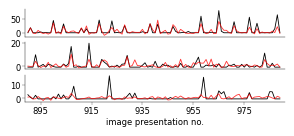

In [17]:
# Set up the layout for plotting
n_rows = 3
n_columns = 1
fig, axes = plt.subplots(n_rows, n_columns, figsize=(3.35,1.2))

# Define frame start and stop for plotting
frame_start=890 
frame_stop =990

# Call a custom plotting function to visualize data for three selected neurons
plot_three_neurons(frame_start, frame_stop, layer_to_predict, sorted_y_preds, evar_neurons_mouse, 'black', axes, animal='mouse', ylim=None, condition_type=None)

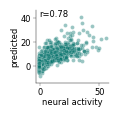

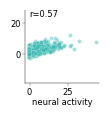

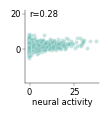

In [14]:
df_ = pd.DataFrame({'actual':layer_to_predict[:,top10neuron], 'predicted':sorted_y_preds[:,top10neuron]})
fig, ax = plt.subplots(figsize=(0.95,0.95))
color = '#007069'
plot_correlations(df_, color, r_position=(0.05,0.9), ax=ax)
ax.set_aspect('equal')
ax.axis('equal')
plt.show()

df = pd.DataFrame({'actual':layer_to_predict[:,med_neuron], 'predicted':sorted_y_preds[:,med_neuron]})
fig, ax = plt.subplots(figsize=(0.95,0.95))
color = 'lightseagreen'
plot_correlations(df, color, r_position=(0.05,0.9), ax=ax)
ax.set_aspect('equal')
ax.axis('equal')
ax.set(ylabel=None)
plt.show()

df = pd.DataFrame({'actual':layer_to_predict[:,bottom10neuron], 'predicted':sorted_y_preds[:,bottom10neuron]})
fig, ax = plt.subplots(figsize=(0.95,0.95))
color = '#73BFB7'
plot_correlations(df, color, r_position=(0.05,0.9), ax=ax)
ax.set_aspect('equal')
ax.axis('equal')
ax.set(ylabel=None)
plt.show()



The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


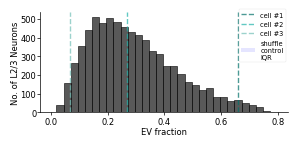

In [17]:


med_evar = evars_resp_mouse[med_neuron]
top_evar = evars_resp_mouse[top10neuron]
bottom_evar = evars_resp_mouse[bottom10neuron]


fig, ax = plt.subplots(figsize=(3.2,1.3))
sns.histplot(df_mouse[(df_mouse['Activity Type']=='stimulus')&(df_mouse.Area=='L23')&(df_mouse['Split-half r']>0.8)&(df_mouse['SNR']>=2)]['EV'], color='#222222', ax=ax,
             linewidth=0.4, binwidth=0.025)

ax.axvline(top_evar, color='#007069', linestyle='--', linewidth=1, label='cell #1', alpha=0.7)
ax.axvline(med_evar, color='lightseagreen', linestyle='--', linewidth=1, label='cell #2', alpha=0.7)
ax.axvline(bottom_evar, color='#73BFB7', linestyle='--', linewidth=1, label='cell #3', alpha=0.7)


data = df_mouse_all[(df_mouse_all['Activity Type']=='stimulus')& (df_mouse_all.SNR > 2) & (df_mouse_all['Split-half r'] > 0.8) & (df_mouse_all.control_shuffle == True) & (df_mouse_all.Area == 'L23')]['EV']
per_25 = np.percentile(data.values, 25)
per_75 = np.percentile(data.values, 75)
ax.axvspan(per_25, per_75, alpha=0.1, color='blue', label='shuffle\ncontrol\nIQR',
        linewidth=0,
        )

ax.set_xlabel('EV fraction', fontsize=6, labelpad=1)
ax.set_ylabel('No. of L2/3 Neurons', fontsize=6, labelpad=1)


# Increase the tick label size for both x and y axes
ax.tick_params(axis='x', labelsize=6, width=0.5, length=2, pad=1)
ax.tick_params(axis='y', labelsize=6, width=0.5, length=2, pad=1)
legend = ax.legend(loc=(0.8,0.5), fontsize=6*0.8)
legend.get_frame().set_linewidth(0.2)
ax.set_xticks(ticks=np.arange(0,0.9,0.2))
ax.spines[:].set_linewidth(0.5)
sns.despine()
plt.savefig(fig_dir +'fig2_mouse_hist.eps',transparent=True,bbox_inches='tight' )
plt.show()

#### supplemental

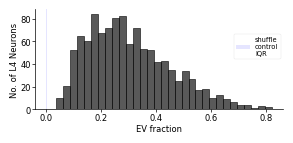

In [8]:
med_evar = evars_resp_mouse[med_neuron]
top_evar = evars_resp_mouse[top10neuron]
bottom_evar = evars_resp_mouse[bottom10neuron]


fig, ax = plt.subplots(figsize=(3.2,1.3))
sns.histplot(df_mouse[(df_mouse['Activity Type']=='stimulus')&(df_mouse.Area=='L4')&(df_mouse['Split-half r']>0.8)&(df_mouse['SNR']>=2)]['EV'], color='#222222', ax=ax,
             linewidth=0.4, binwidth=0.025)

data = df_mouse_all[(df_mouse_all['Activity Type']=='stimulus')& (df_mouse_all.SNR > 2) & (df_mouse_all['Split-half r'] > 0.8) & (df_mouse_all.control_shuffle == True) & (df_mouse_all.Area == 'L4')]['EV']
per_25 = np.percentile(data.values, 25)
per_75 = np.percentile(data.values, 75)
ax.axvspan(per_25, per_75, alpha=0.1, color='blue', label='shuffle\ncontrol\nIQR',
        linewidth=0,
           )

ax.set_xlabel('EV fraction', fontsize=6, labelpad=1)
ax.set_ylabel('No. of L4 Neurons', fontsize=6, labelpad=1)


# Increase the tick label size for both x and y axes
ax.tick_params(axis='x', labelsize=6, width=0.5, length=2, pad=1)
ax.tick_params(axis='y', labelsize=6, width=0.5, length=2, pad=1)
legend = ax.legend(loc=(0.8,0.5), fontsize=6*0.8)
legend.get_frame().set_linewidth(0.2)
ax.set_xticks(ticks=np.arange(0,0.9,0.2))
ax.spines[:].set_linewidth(0.5)
sns.despine()
plt.show()

In [23]:
## label visual responsive or non-responsive neurons
df_mouse.loc[:,'Visual\nResponsiveness']=['responsive' if x > 0.8 and y > 2 else 'non-responsive' for x, y in zip(df_mouse['Split-half r'], df_mouse['SNR'])]
df_mouse.loc[:,'SNR > 2']=[True if y > 2 else False for _, y in zip(df_mouse['Split-half r'], df_mouse['SNR'])]
df_mouse.loc[:,'reliable']=[True if x > 0.8 else False for x, _ in zip(df_mouse['Split-half r'], df_mouse['SNR'])]
print(df_mouse.groupby(['Visual\nResponsiveness'])['EV'].agg('count'))


Visual\nResponsiveness
non-responsive    47311
responsive         8371
Name: EV, dtype: int64


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


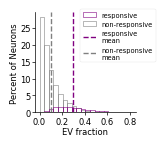

In [226]:
fig, ax = plt.subplots(figsize=(1.3,1.3))
plot = sns.histplot(df_mouse, x='EV', fill=False, hue='Visual\nResponsiveness', color='#222222', ax=ax,hue_order=['responsive','non-responsive'],
            linewidth=0.4, bins=20, palette=['purple', 'gray'], stat='percent')
ax.axvline(df_mouse[df_mouse['Visual\nResponsiveness']=='responsive']['EV'].mean(), color='purple', linestyle='--', linewidth=1, label='responsive\nmean EV', alpha=1)
ax.axvline(df_mouse[df_mouse['Visual\nResponsiveness']=='non-responsive']['EV'].mean(), color='gray', linestyle='--', linewidth=1, label='non-responsive\nmean EV', alpha=1)

ax.set_xlabel('EV fraction', fontsize=6, labelpad=1)
ax.set_ylabel(f'Percent of Neurons', fontsize=6, labelpad=1)
# Increase the tick label size for both x and y axes
ax.tick_params(axis='x', labelsize=6, width=0.5, length=2, pad=1)
ax.tick_params(axis='y', labelsize=6, width=0.5, length=2, pad=1)

ax.set_xticks(ticks=np.arange(0,0.9,0.2))
ax.spines[:].set_linewidth(0.5)
sns.despine()
legend = ax.get_legend()
handles1= legend.legend_handles
handles2, labels = ax.get_legend_handles_labels()
handles = handles1 + handles2
ax.legend(handles=handles, 
        labels=['responsive','non-responsive', 'responsive\nmean','non-responsive\nmean'], 
        fontsize=6*0.8,
        loc=(0.45,0.5),
        alignment='center')
ax.legend_.get_frame().set_linewidth(0.2)
plt.savefig(fig_dir +'fig2_supp_mouse_visual_nonvisual.eps',transparent=True,bbox_inches='tight' )
plt.show()

In [122]:
df_all = df_mouse.copy().reset_index()
df_all['cell type']='all'
df_snr = df_mouse[df_mouse['SNR > 2']==True].reset_index()
df_snr['cell type']='SNR > 2'
df_filt = df_mouse[df_mouse['Visual\nResponsiveness']=='responsive'].reset_index()
df_filt['cell type']='SNR > 2 &\nsplit-half r >0.8'
df_reli = df_mouse[df_mouse['reliable']==True].reset_index()
df_reli['cell type']='split-half r >0.8'
df_conditions_comparisons_mouse = pd.concat([df_all,df_reli,df_snr, df_filt]).reset_index()

In [25]:
def is_factor_of_4(number):
    return number % 4 == 0

def get_x_positions(violin):
    # Calculate x positions of the middle of the violins
    x_positions = []
    for patch in violin.collections:
        # Get the x coordinates of the patch and calculate its middle
        x_coordinates = patch.get_paths()[0].vertices[:, 0]
        middle = np.mean(x_coordinates)
        x_positions.append(middle)
    new_positions = [x for count, x in enumerate(x_positions) if not is_factor_of_4(count)]
    return new_positions

def get_ext_fig_stars(df_, x_label='Mouse Name', dep_var ='EV', 
                    ind_var = 'cell type', 
                    stat_names=['all_split-half r >0.8','split-half r >0.8_SNR > 2','SNR > 2_SNR > 2 &\nsplit-half r >0.8'],
                    ):
    all_stars = []
    for label in df_[x_label].unique():
        pvalnames, stars  = get_oneway_anova_stars(df_[df_[x_label]==label], dependent_variable=ind_var, dependent_variable_order=df_[ind_var].unique(),
                                        neuron_property=dep_var)
        stars_dict = {p:s for p, s in zip(pvalnames, stars)}
        for stat_name in stat_names:
            all_stars.append(stars_dict[stat_name])
    return all_stars

In [228]:
all_stars = get_ext_fig_stars(df_conditions_comparisons_mouse)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


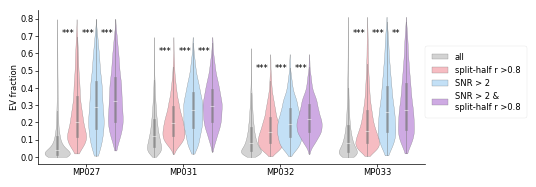

In [229]:
fig, ax = plt.subplots(figsize=(5,2))
violin = sns.violinplot(df_conditions_comparisons_mouse,  y='EV', x='Mouse Name', hue='cell type', ax=ax,
            palette=['lightgray','#ffb3ba','#bae1ff','#d0a0ec'],
            inner_kws={'box_width':2, 'marker':'_', 'markersize':3,
                            'markeredgewidth':0.75,'alpha':0.5},
            gap=-.3, cut=0,
            linewidth=0.2)
ax.set_xlabel(None)
ax.set_ylabel(f'EV fraction', fontsize=6, labelpad=1)

ax.tick_params(axis='x', labelsize=6, width=0.5, length=2, pad=1)
ax.tick_params(axis='y', labelsize=6, width=0.5, length=2, pad=1)
ax.legend(alignment='center',
title_fontsize= 6, fontsize=6, loc= (1,0.3),
borderpad=0.75)
ax.legend_.get_frame().set_linewidth(0.2)
ax.spines[:].set_linewidth(0.5)
sns.despine()

x_positions = get_x_positions(violin)   
y_positions = [0.7,0.7,0.7,
            0.6,0.6,0.6,
            0.5,0.5,0.5,
            0.7,0.7,0.7,
            ]
for count, (x_pos, star, y_pos) in enumerate(zip(x_positions, all_stars,y_positions)):
    ax.text(x=x_pos-0.15, y=y_pos, s=star, 
            fontsize=6)
plt.savefig(fig_dir +'fig2_supp_mouse_EV_filter_comparisons.eps',transparent=True,bbox_inches='tight' )
plt.show()

## macaque predictions

### coding

In [7]:
#depending on the dataset type, there are different times of autocorrelation to mitigate
all_frames_reduced = {'SNR': 5, 'SNR_spont': 5, 'RS': 20, 
                      'RS_open':20, 'RS_closed': 20, 
                      'RF_thin':25, 'RF_large':25, 'RF_thin_spont':25, 'RF_large_spont':25}
#different stimulus presentaion types have different durations
all_ini_stim_offs = {'SNR': 400, 'SNR_spont': 300, 'RS': None,
                      'RS_open':None, 'RS_closed': None, 
                      'RF_thin':1000, 'RF_large':1000, 'RF_thin_spont':300, 
                      'RF_large_spont':300}

In [ ]:
monkey_stats=create_empty_monkey_stats_dict()
get_split_half_r_monkey_all_dates(monkey_stats)
get_SNR_monkey_all_dates(monkey_stats)
store_macaque_alphas(main_dir, monkey_stats, verbose=True)

get_evar_monkey_all_dates(monkey_stats, control_shuffle=False)
get_evar_monkey_all_dates(monkey_stats, control_shuffle=True)

### plotting

In [4]:
df_monkey_all = make_monkey_df(monkey_stats)
df_monkey = df_monkey_all[df_monkey_all.control_shuffle==False]

In [15]:
condition_type= 'SNR'
date = get_dates(condition_type)[1]
monkey_reli = monkey_stats[condition_type][date]['V4']['split_half_r']
v4_evars_resp=monkey_stats[condition_type][date]['V4']['evars'][monkey_reli > 0.8]
all_evars_monkey= df_monkey[(df_monkey['Area']=='V4')&(df_monkey['Split-half r']>0.8)&(df_monkey['SNR']>2)]['EV'].values

sorted_indices = np.argsort(all_evars_monkey)[::-1]
percentage = int(0.13 * len(all_evars_monkey))
top_threshold = all_evars_monkey[sorted_indices[percentage]]
bottom_threshold = all_evars_monkey[sorted_indices[-percentage]]
top_indices = np.argwhere(v4_evars_resp>top_threshold)[:,0]
bottom_indices = np.argwhere(v4_evars_resp<bottom_threshold)[:,0]
np.random.seed(17)
top10neuron= np.random.choice(top_indices)
np.random.seed(17)
bottom10neuron= np.random.choice(bottom_indices)

median_ = df_monkey[(df_monkey['Area']=='V4')&(df_monkey['Split-half r']>0.8)&(df_monkey['SNR']>2)]['EV'].median()
med_neuron = np.argwhere(np.isclose(v4_evars_resp, median_, rtol=1e-02, atol=1e-02, equal_nan=False))[0][0]
evar_neurons_monkey = [top10neuron,med_neuron, bottom10neuron]


resp_V4, resp_V1 =get_resps(condition_type=condition_type, date=date, w_size=25, stim_on=0, stim_off=400)
layer_to_predict = resp_V4[:,monkey_reli > 0.8]
layer_to_use = resp_V1

frame_size = 500
alpha = monkey_stats['monkey_alphas'][frame_size]['V4']
sorted_y_preds,evars = get_predictions_evars_parallel(layer_to_use, layer_to_predict, alpha=alpha, 
                                                        n_splits=10, frames_reduced=5)

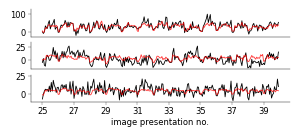

In [16]:
n_rows = 3
n_columns = 1
fig, axes = plt.subplots(n_rows, n_columns, figsize=(3.35,1.2))
frame_start=25
frame_stop =40
plot_three_neurons(frame_start, frame_stop, layer_to_predict, sorted_y_preds, evar_neurons_monkey, 'black', axes, animal='monkey', ylim=None, condition_type='SNR')
plt.show()

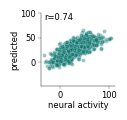

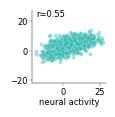

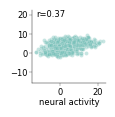

In [17]:
df_ = pd.DataFrame({'actual':layer_to_predict[:,top10neuron], 'predicted':sorted_y_preds[:,top10neuron]})
fig, ax = plt.subplots(figsize=(0.95,0.95))
color = '#007069'
plot_correlations(df_, color, r_position=(0.05,0.9), ax=ax)
ax.set_aspect('equal')
ax.axis('equal')
plt.show()

df = pd.DataFrame({'actual':layer_to_predict[:,med_neuron], 'predicted':sorted_y_preds[:,med_neuron]})
fig, ax = plt.subplots(figsize=(0.95,0.95))
color = 'lightseagreen'
plot_correlations(df, color, r_position=(0.05,0.9), ax=ax)
ax.set_aspect('equal')
ax.axis('equal')
ax.set_ylabel(None)
plt.show()

df = pd.DataFrame({'actual':layer_to_predict[:,bottom10neuron], 'predicted':sorted_y_preds[:,bottom10neuron]})
fig, ax = plt.subplots(figsize=(0.95,0.95))
color = '#73BFB7'
plot_correlations(df, color, r_position=(0.05,0.9), ax=ax)
ax.set_aspect('equal')
ax.axis('equal')
ax.set_ylabel(None)
plt.show()

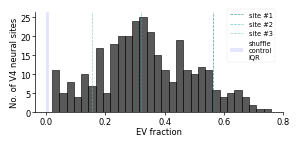

In [18]:
med_evar = v4_evars_resp[med_neuron]
top_evar = v4_evars_resp[top10neuron]
bottom_evar = v4_evars_resp[bottom10neuron]


fig, ax = plt.subplots(figsize=(3.2,1.3))
sns.histplot(df_monkey[(df_monkey['Area']=='V4')&(df_monkey['Split-half r']>0.8)&(df_monkey['SNR']>2)]['EV'], 
                color='#222222', ax=ax, binwidth=0.025, linewidth=0.4)




ax.axvline(top_evar, color='#007069', linestyle='--', linewidth=0.5, label='site #1', alpha=0.7)
ax.axvline(med_evar, color='lightseagreen', linestyle='--', linewidth=0.5, label='site #2', alpha=0.7)
ax.axvline(bottom_evar, color='#73BFB7', linestyle='--', linewidth=0.5, label='site #3', alpha=0.7)


data = df_monkey_all[(df_monkey_all['Split-half r']>0.8)&(df_monkey_all['SNR']>2)&(df_monkey_all.control_shuffle==True)&(df_monkey_all.Area=='V4')]['EV']
per_25 = np.percentile(data.values, 25)
per_75 = np.percentile(data.values, 75)
ax.axvspan(per_25, per_75, alpha=0.1, color='blue', label='shuffle\ncontrol\nIQR',
        linewidth=0,
        )

ax.set_xlabel('EV fraction', fontsize=6, labelpad=1)
ax.set_ylabel('No. of V4 neural sites', fontsize=6, labelpad=1)

# Increase the tick label size for both x and y axes
ax.tick_params(axis='x', labelsize=6, width=0.5, length=2, pad=1)
ax.tick_params(axis='y', labelsize=6, width=0.5, length=2, pad=1)
legend = ax.legend(loc=(0.775,0.5), fontsize=6*0.8)
legend.get_frame().set_linewidth(0.2)
ax.set_xticks(ticks=np.arange(0,0.9,0.2))
ax.spines[:].set_linewidth(0.5)
sns.despine()
plt.show()

#### supplemental

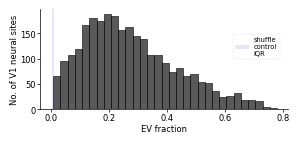

In [19]:
fig, ax = plt.subplots(figsize=(3.2,1.3))
sns.histplot(df_monkey[(df_monkey['Area']=='V1')&(df_monkey['Split-half r']>0.8)&(df_monkey['SNR']>2)]['EV'], 
        color='#222222', ax=ax, binwidth=0.025, linewidth=0.4)


data = df_monkey_all[(df_monkey_all['Split-half r']>0.8)&(df_monkey_all['SNR']>2)&(df_monkey_all.control_shuffle==True)&(df_monkey_all.Area=='V1')]['EV']
per_25 = np.percentile(data.values, 25)
per_75 = np.percentile(data.values, 75)
ax.axvspan(per_25, per_75, alpha=0.1, color='blue', label='shuffle\ncontrol\nIQR',
        linewidth=0,
)

ax.set_xlabel('EV fraction', fontsize=6, labelpad=1)
ax.set_ylabel('No. of V1 neural sites', fontsize=6, labelpad=1)

# Increase the tick label size for both x and y axes
ax.tick_params(axis='x', labelsize=6, width=0.5, length=2, pad=1)
ax.tick_params(axis='y', labelsize=6, width=0.5, length=2, pad=1)
legend = ax.legend(loc=(0.775,0.5), fontsize=6*0.8)
legend.get_frame().set_linewidth(0.2)
ax.set_xticks(ticks=np.arange(0,0.9,0.2))
ax.spines[:].set_linewidth(0.5)
sns.despine()
plt.show()

In [20]:

df_monkey.loc[:,'Visually Responsive']=[True if x > 0.8 and y > 2 else False for x, y in zip(df_monkey['Split-half r'], df_monkey['SNR'])]

/var/folders/1q/qnh3vzw91s17bbgybp9sb0_r0000gn/T/ipykernel_80747/3721056533.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_monkey.loc[:,'Visually Responsive']=[True if x > 0.8 and y > 2 else False for x, y in zip(df_monkey['Split-half r'], df_monkey['SNR'])]


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


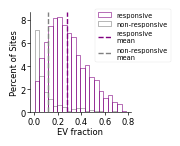

In [21]:
## 

fig, ax = plt.subplots(figsize=(1.3,1.3))
sns.histplot(df_monkey, x='EV', hue='Visually Responsive', fill=False, color='#222222', ax=ax,hue_order=[True,False],
        linewidth=0.4, bins=20, palette=['purple','gray'], stat='percent')
ax.axvline(df_monkey[df_monkey['Visually Responsive']==True]['EV'].mean(), color='purple', linestyle='--', linewidth=1, label='responsive\nmean EV', alpha=1)
ax.axvline(df_monkey[df_monkey['Visually Responsive']==False]['EV'].mean(), color='gray', linestyle='--', linewidth=1, label='non-responsive\nmean EV', alpha=1)

ax.set_xlabel('EV fraction', fontsize=6, labelpad=1)
ax.set_ylabel(f'Percent of Sites', fontsize=6, labelpad=1)
# Increase the tick label size for both x and y axes
ax.tick_params(axis='x', labelsize=6, width=0.5, length=2, pad=1)
ax.tick_params(axis='y', labelsize=6, width=0.5, length=2, pad=1)

legend = ax.get_legend()
handles1= legend.legend_handles
handles2, labels = ax.get_legend_handles_labels()
handles = handles1 + handles2
ax.legend(handles=handles, 
        labels=['responsive','non-responsive', 'responsive\nmean','non-responsive\nmean'], 
        fontsize=6*0.8,
        loc=(0.65,0.5),
        alignment='center')
ax.set_xticks(ticks=np.arange(0,0.9,0.2))
ax.legend_.get_frame().set_linewidth(0.2)
ax.spines[:].set_linewidth(0.45)
sns.despine()
plt.savefig(fig_dir +'fig2_supp_monkey_visual_nonvisual.eps',transparent=True,bbox_inches='tight' )
plt.show()

In [22]:
## 
df_monkey.loc[:,'Visually Responsive']=[True if x > 0.8 and y > 2 else False for x, y in zip(df_monkey['Split-half r'], df_monkey['SNR'])]
df_monkey.loc[:,'SNR > 2']=[True if y > 2 else False for _, y in zip(df_monkey['Split-half r'], df_monkey['SNR'])]
df_monkey.loc[:,'reliable']=[True if x > 0.8 else False for x, _ in zip(df_monkey['Split-half r'], df_monkey['SNR'])]

/var/folders/1q/qnh3vzw91s17bbgybp9sb0_r0000gn/T/ipykernel_80747/2612100273.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_monkey.loc[:,'SNR > 2']=[True if y > 2 else False for _, y in zip(df_monkey['Split-half r'], df_monkey['SNR'])]
/var/folders/1q/qnh3vzw91s17bbgybp9sb0_r0000gn/T/ipykernel_80747/2612100273.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_monkey.loc[:,'reliable']=[True if x > 0.8 else False for x, _ in zip(df_monkey['Split-half r'], df_monkey['SNR'])]


In [23]:
df_all = df_monkey.copy().reset_index()
df_all['cell type']='all'
df_snr = df_monkey[df_monkey['SNR > 2']==True].reset_index()
df_snr['cell type']='SNR > 2'
df_filt = df_monkey[df_monkey['Visually Responsive']==True].reset_index()
df_filt['cell type']='SNR > 2 &\nsplit-half r >0.8'
df_reli = df_monkey[df_monkey['reliable']==True].reset_index()
df_reli['cell type']='split-half r >0.8'
df_conditions_comparisons_monkey = pd.concat([df_all,df_reli,df_snr, df_filt]).reset_index()

In [ ]:
all_stars = get_ext_fig_stars(df_conditions_comparisons_monkey,x_label='Activity Type')
pvalnames, stars  = get_oneway_anova_stars(df_conditions_comparisons_monkey, dependent_variable='cell type',
                                           dependent_variable_order=df_conditions_comparisons_monkey['cell type'].unique(),
                                        neuron_property='EV')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


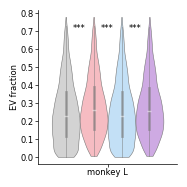

In [27]:
fig, ax = plt.subplots(figsize=(1.8,2))
violin=sns.violinplot(df_conditions_comparisons_monkey,  y='EV', x='Activity Type', hue='cell type', ax=ax,
            palette=['lightgray','#ffb3ba','#bae1ff','#d0a0ec'],
            inner_kws={'box_width':2, 'marker':'_', 'markersize':3,
                            'markeredgewidth':1,'alpha':0.5},
            linewidth=0.4,cut=0)
ax.set_xlabel(None)
ax.set_ylabel(f'EV fraction', fontsize=6, labelpad=1)
ax.set_xticks(ticks=[0], labels=['monkey L'])
ax.tick_params(axis='x', labelsize=6, width=0.5, length=2, pad=1)
ax.tick_params(axis='y', labelsize=6, width=0.5, length=2, pad=1)
ax.legend(loc=(1,0.5), fontsize=5)
ax.spines[:].set_linewidth(0.5)
sns.despine()

x_positions = get_x_positions(violin)   
y_positions = [0.7,0.7,0.7,
            ]
for count, (x_pos, star, y_pos) in enumerate(zip(x_positions, all_stars,y_positions)):
    ax.text(x=x_pos-0.15, y=y_pos, s=star, 
            fontsize=6)
ax.legend_.get_frame().set_linewidth(0.5)
ax.legend_.remove()
plt.savefig(fig_dir +'fig2_supp_monkey_EV_filter_comparisons.eps',transparent=True,bbox_inches='tight' )
plt.show()